# Topog form stress using MOM025 DATA

Recent update 22 Oct 2017

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import pickle
from numpy import math

import pandas as pd
import xarray as xr
from glob import glob
from mpl_toolkits.basemap import Basemap, shiftgrid


# Load Data

In [2]:
#/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7/output100/ocean/ocean.nc

DataDir = '/g/data3/hh5/tmp/cosima/access-om2-025'
expts = ['025deg_jra55_ryf_spinup7']

In [14]:
g=9.8

z=np.zeros([1080,1440]).astype(np.int64) 

for e in expts:
    ExpDir = os.path.join(DataDir,e)
    FileList1 = glob(os.path.join(ExpDir, 'output10*/ocean/ocean_grid.nc'))
    FileList1.sort()
    dsx1 = xr.open_mfdataset(FileList1, concat_dim='time',decode_times=False, engine='netcdf4')
    kmt = dsx1.kmt.mean('time').values
    depth = dsx1.ht.mean('time').values
    z[:,:]=kmt[:,:]-1
    dxu = dsx1.dxu.mean('time').values
    FileList2 = glob(os.path.join(ExpDir, 'output10*/ocean/ocean_month.nc'))
    FileList2.sort()
    dsx2 = xr.open_mfdataset(FileList2, concat_dim='time',decode_times=False, engine='netcdf4')    
    pbot = 10000*dsx2.pbot_t.mean('time').values   # p_bot
    tau = dxu*dsx2.tau_x.mean('time').values
    bmf = dxu*dsx2.bmf_u.mean('time').values
    eta= dsx2.eta_t.mean('time').values
    FileList3 = glob(os.path.join(ExpDir, 'output10*/ocean/ocean.nc'))
    FileList3.sort()
    dsx3 = xr.open_mfdataset(FileList3, concat_dim='time',decode_times=False, engine='netcdf4')      
    tmp1= dsx3.dzt.mean('time')      # t-cell thickness
    dz=tmp1[:,:,:].values
    tmp2 = dsx3.rho.mean('time')      # \rho in-situ
    rho=tmp2[:,:,:].values


In [9]:
%%time
pf=np.zeros([50,1080,1440])# store pbot*dz in each z-cell

for y in range(100,360):           
    for x in range(0,1440):
        if (z[y,x]>-1)&(z[y,x-1]>-1):      # x & x-1 are not continent landmasses  
            if z[y,x]-z[y,x-1]==0:
                dz1=depth[y,x-1]-depth[y,x]
                if dz1<0:
                    rhom=rho[z[y,x],y,x]
                    pf[z[y,x],y,x-1]=pf[z[y,x],y,x-1]+(pbot[y,x]*(-dz1)-g*rhom*(dz1)**2/2)
                elif (dz1)>0:
                    rhom=rho[z[y,x-1],y,x-1]
                    pf[z[y,x],y,x]=pf[z[y,x],y,x]-1*(pbot[y,x-1]*(dz1)-g*rhom*(dz1)**2/2)
            else:
                if depth[y,x]-depth[y,x-1]>0:
                    dz1=depth[y,x]-depth[y,x-1]   # total depth difference
                    pa=pbot[y,x]          # choose pbot pressure
                    zm=dz[z[y,x],y,x]             # dz of lowest layer
                    rhom=rho[z[y,x],y,x]          # density
                    pm = pa-zm*g*rhom/2       #pressure at middle of each partial cell
                    pf[z[y,x],y,x-1]=pf[z[y,x],y,x-1]+pm*zm
                    pa=pa-zm*g*rhom           #update press reference to upper partial cell
                    dz1=dz1-zm                    
                    for i in range(1,z[y,x]-z[y,x-1]):  #calculate from bottom partial cell in each layer             
                        zm=dz[z[y,x]-i,y,x]        
                        rhom=rho[z[y,x]-i,y,x]          #density
                        pm = pa-zm*g*rhom/2         #pressure at middle of each partial cell
                        pf[z[y,x]-i,y,x-1]=pf[z[y,x]-i,y,x-1]+pm*zm
                        pa=pa-zm*g*rhom             #update press reference to upper partial cell
                        dz1=dz1-zm
                    zm=dz1 # The top cell
                    rhom=rho[z[y,x-1],y,x]                
                    pm = pa-zm*g*rhom/2
                    pf[z[y,x-1],y,x-1]=pf[z[y,x-1],y,x-1]+pm*zm 
                elif depth[y,x]-depth[y,x-1]<0:
                    dz1=depth[y,x-1]-depth[y,x]
                    pa=pbot[y,x-1]
                    zm=dz[z[y,x-1],y,x-1]
                    rhom=rho[z[y,x-1],y,x-1]
                    pm = pa-zm*g*rhom/2
                    pf[z[y,x-1],y,x]=pf[z[y,x-1],y,x]-pm*zm
                    pa=pa-zm*g*rhom 
                    dz1=dz1-zm
                    for i in range(1,z[y,x-1]-z[y,x]):
                        zm=dz[z[y,x-1]-i,y,x-1]
                        rhom=rho[z[y,x-1]-i,y,x-1]
                        pm = pa-zm*g*rhom/2
                        pf[z[y,x-1]-i,y,x]=pf[z[y,x-1]-i,y,x]-pm*zm
                        pa=pa-zm*g*rhom 
                        dz1=dz1-zm
                    zm=dz1
                    rhom=rho[z[y,x],y,x-1]                
                    pm = pa-zm*g*rhom/2
                    pf[z[y,x],y,x]=pf[z[y,x],y,x]-pm*zm
        elif (z[y,x]==0)&(z[y,x-1]<-1):      # only x-1 is continent landmass
            pa=pbot[y,x]
            for i in range(0,z[y,x]+1):
                zm=dz[z[y,x]-i,y,x]
                rhom=rho[z[y,x]-i,y,x]
                pm = pa-zm*g*rhom/2
                pf[z[y,x]-i,y,x-1]=pf[z[y,x]-i,y,x-1]+pm*zm
                pa=pa-zm*g*rho
        elif (z[y,x]>0)&(z[y,x-1]<-1):      # only x-1 is continent landmass
            pa=pbot[y,x]
            zm=dz[z[y,x],y,x]
            rhom=rho[z[y,x],y,x]
            pm = pa-zm*g*rhom/2
            pf[z[y,x],y,x-1]=pf[z[y,x],y,x-1]+pm*zm
            pa=pa-zm*g*rhom
            for i in range(1,z[y,x]+1):
                zm=dz[z[y,x]-i,y,x]
                rhom=rho[z[y,x]-i,y,x]
                pm = pa-zm*g*rhom/2
                pf[z[y,x]-i,y,x-1]=pf[z[y,x]-i,y,x-1]+pm*zm
                pa=pa-zm*g*rhom
        elif (z[y,x]<-1)&(z[y,x-1]==0):     # only x is continent landmass
            pa=pbot[y,x-1]
            for i in range(0,z[y,x-1]+1):
                zm=dz[z[y,x-1]-i,y,x-1]
                rhom=rho[z[y,x-1]-i,y,x-1]
                pm = pa-zm*g*rhom/2
                pf[z[y,x-1]-i,y,x]=pf[z[y,x-1]-i,y,x]-pm*zm
                pa=pa-zm*g*rhom                                   
        elif (z[y,x]<-1)&(z[y,x-1]>0):     # only x is continent landmass
            pa=pbot[y,x-1]
            zm=dz[z[y,x-1],y,x-1]
            rhom=rho[z[y,x-1],y,x-1]
            pm = pa-zm*g*rhom/2
            pf[z[y,x-1],y,x]=pf[z[y,x-1],y,x]-pm*zm
            pa=pa-zm*g*rhom
            for i in range(1,z[y,x-1]+1):
                zm=dz[z[y,x-1]-i,y,x-1]
                rhom=rho[z[y,x-1]-i,y,x-1]
                pm = pa-zm*g*rhom/2
                pf[z[y,x-1]-i,y,x]=pf[z[y,x-1]-i,y,x]-pm*zm
                pa=pa-zm*g*rhom

-393424586.425


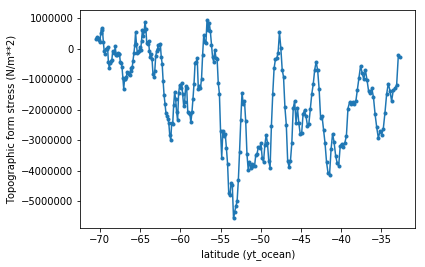

In [11]:
# form stress term

lat = dsx1.yt_ocean[100:360]
ts=np.sum(pf[:,100:360,:],axis=0)
plt.plot(lat,np.sum(ts,axis=1),'.-')
plt.xlabel('latitude (yt_ocean)')
plt.ylabel('Topographic form stress (N/m**2)')
print np.sum(pf[:,100:360,:])

In [48]:
depth[np.isnan(depth)]=0

## new_dH using new_d, new_dH(n+1)=new_d(n+2)-new_d(n)
dH = np.zeros([1080,1440])
dH[:,1:-1] = 0.5*(depth[:,2:] - depth[:,:-2])
dH[:,0] = 0.5*(depth[:,1]- depth[:,-1])
dH[:,-1] = 0.5*(depth[:,0]- depth[:,-2])

(-50000000.0, 30000000.0)

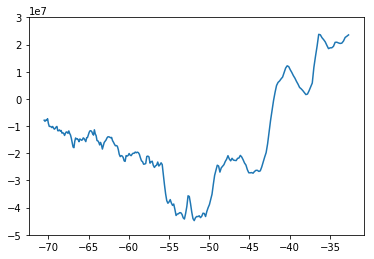

In [46]:
## rho0*g*eta*dH
tmp1 = 9.8*1035*eta*dH
tmp1[np.isnan(tmp1)]=0
plt.plot(lat,np.sum(tmp1[100:360,:],axis=1))
plt.ylim([-5e7,3e7])

28686731.6805


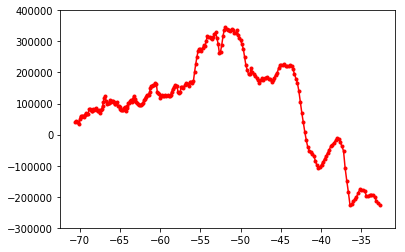

In [47]:
## (rho-rho0)*g*eta*dH
tmp2 = 9.8*(rho[0,:,:]-1035)*eta*dH
tmp2[np.isnan(tmp2)]=0
plt.plot(lat,np.sum(tmp2[100:360,:],axis=1),marker='.',color='r')
plt.ylim([-300000,400000])
print np.sum(tmp2[100:360,:])

442114291.471


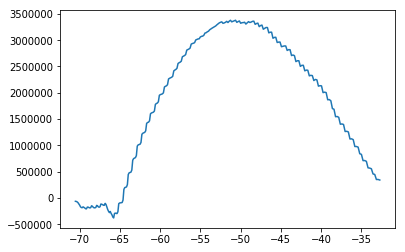

In [31]:
#wind stress term

tau[np.isnan(tau)]=0
plt.plot(lat,np.sum(tau[100:360,:],axis=1))

print np.sum(tau[100:360,:])

-18463.7648607


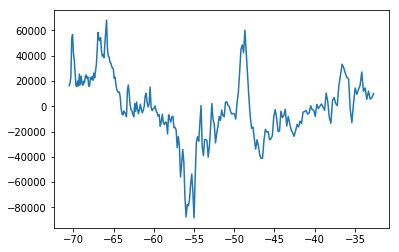

In [34]:
## friction term

bmf[np.isnan(bmf)]=0
plt.plot(lat,np.sum(-bmf[100:360,:],axis=1))

print np.sum(-bmf[100:360,:])

-624251.838325


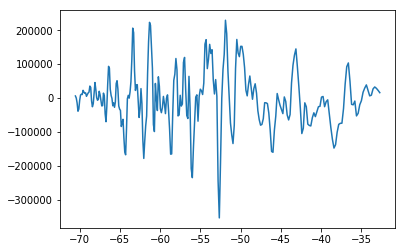

In [69]:
## momtum term

u = dsx3.u.mean('time').values
v = dsx3.v.mean('time').values
dyu = dsx1.dyu.mean('time').values

uvdz = u*v*dz
uvdz[np.isnan(uvdz)]=0
int_uv_dz=np.sum(uvdz,axis=0)
int_uv_dz[np.isnan(int_uv_dz)]=0

uvdz_dy = np.zeros([1080,1440])
uvdz_dy[1:-1] = (int_uv_dz[2:]-int_uv_dz[:-2])/2
uvdz_dy[0] = (int_uv_dz[1]-int_uv_dz[-1])/2
uvdz_dy[-1] = (int_uv_dz[0]-int_uv_dz[-2])/2

kernal = -1035*dxu*uvdz_dy/dyu
kernal[np.isnan(kernal)]=0
plt.plot(lat,np.sum(kernal[100:360,:],axis=1))
         
print np.sum(kernal[100:360])

### Comment: 
### form stress: -3.93*10^8
### wind stress: 4.4*10^8
### friction: -1.9*10^4
### momentum: -6.3*10^5